In [2]:
import keras,os,matplotlib.pyplot as plt,glob,pandas as pd,seaborn as sn
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import scipy

2022-11-27 08:28:18.651619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-27 08:28:18.651690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-27 08:28:18.651695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


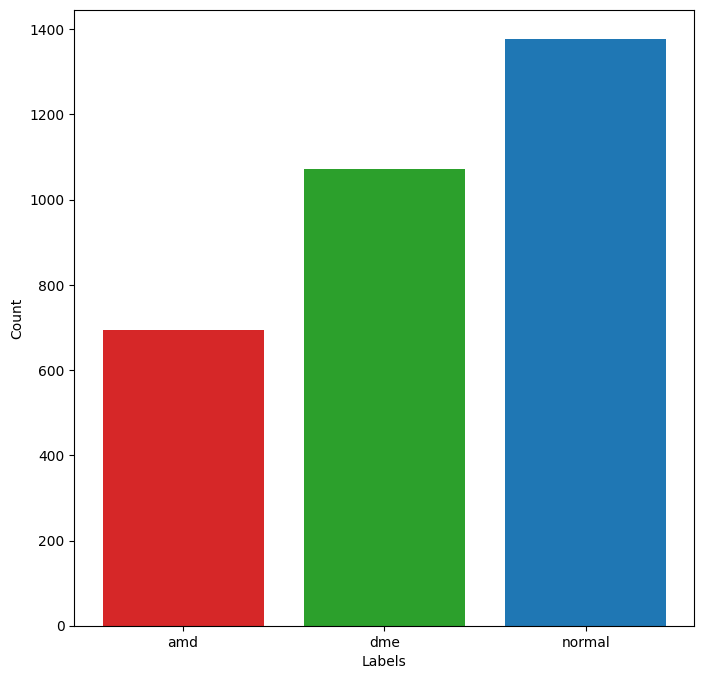

In [3]:
amd_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/amd"))
dme_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/dme"))
normal_images = len(os.listdir(r"/home/kmh/Desktop/newnewdataset/training/normal"))
data= {'amd': amd_images, 'dme': dme_images, 'normal': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

batchSize=16

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

In [4]:
trdata = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)
traindata = trdata.flow_from_directory(
    directory="/home/kmh/Desktop/newnewdataset/training",
    target_size=(224,224),
    batch_size= batchSize,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

tsdata = ImageDataGenerator(
    rescale= 1./255,
)
testdata = tsdata.flow_from_directory(
    directory="/home/kmh/Desktop/newnewdataset/testing", 
    target_size=(224,224),
    batch_size= batchSize,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

Found 3141 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [5]:
num_classes = len(traindata.class_indices)  
train_labels = traindata.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = testdata.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(traindata.filenames)  
nb_valid_samples = len(testdata.filenames)

In [6]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

model.summary()

2022-11-27 08:28:20.827967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-27 08:28:20.828376: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 08:28:20.828393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kmh): /proc/driver/nvidia/version does not exist
2022-11-27 08:28:20.829118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [7]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/home/kmh/Desktop/SEM7/DL/proj-test/env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
checkpoint = ModelCheckpoint(
   'newtemp_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

# csvlogger = CSVLogger(
#     filename= "baseline_training_csv.log",
#     separator = ",",
#     append = False
# )

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, reduceLR]

In [9]:
history = model.fit(
    traindata, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batchSize,
    validation_data = testdata, 
    validation_steps = nb_valid_samples//batchSize,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.83259, saving model to newtemp_model.h5
196/196 - 1190s - loss: 0.7975 - accuracy: 0.6125 - val_loss: 0.8326 - val_accuracy: 0.6625 - lr: 1.0000e-04 - 1190s/epoch - 6s/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.83259
196/196 - 1166s - loss: 0.6308 - accuracy: 0.6877 - val_loss: 1.0058 - val_accuracy: 0.6500 - lr: 1.0000e-04 - 1166s/epoch - 6s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.83259 to 0.66253, saving model to newtemp_model.h5
196/196 - 1213s - loss: 0.5641 - accuracy: 0.7155 - val_loss: 0.6625 - val_accuracy: 0.6250 - lr: 1.0000e-04 - 1213s/epoch - 6s/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.66253
196/196 - 1182s - loss: 0.4991 - accuracy: 0.7645 - val_loss: 0.6867 - val_accuracy: 0.6125 - lr: 1.0000e-04 - 1182s/epoch - 6s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.66253 to 0.65569, saving model to newtemp_model.h5
196/196 - 1192s - loss: 0.4367 - accuracy: 0.7837 - val_loss: 0

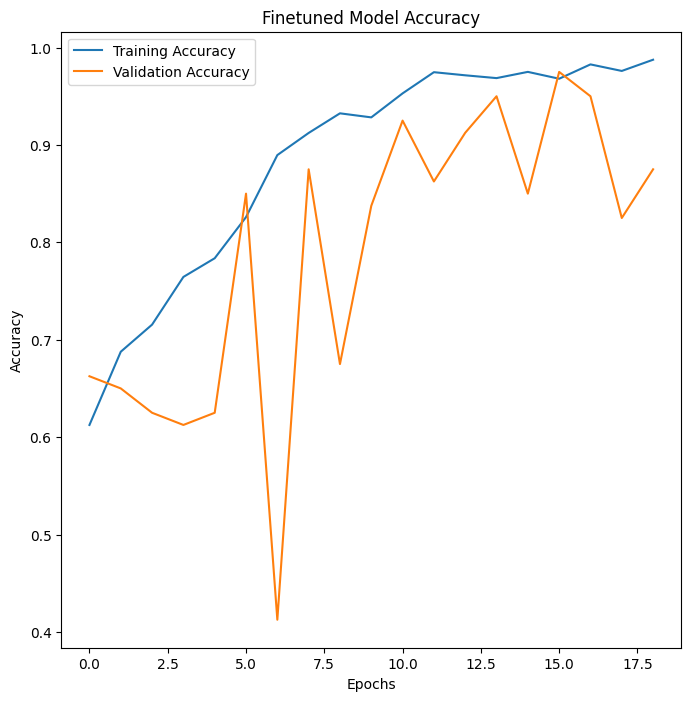

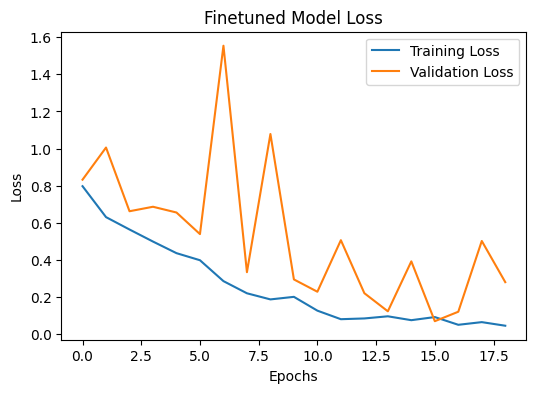

In [10]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [1]:
(eval_loss, eval_accuracy) = model.evaluate(testdata, batch_size= batchSize, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

NameError: name 'model' is not defined

6/6 [==============================] - 12s 2s/step


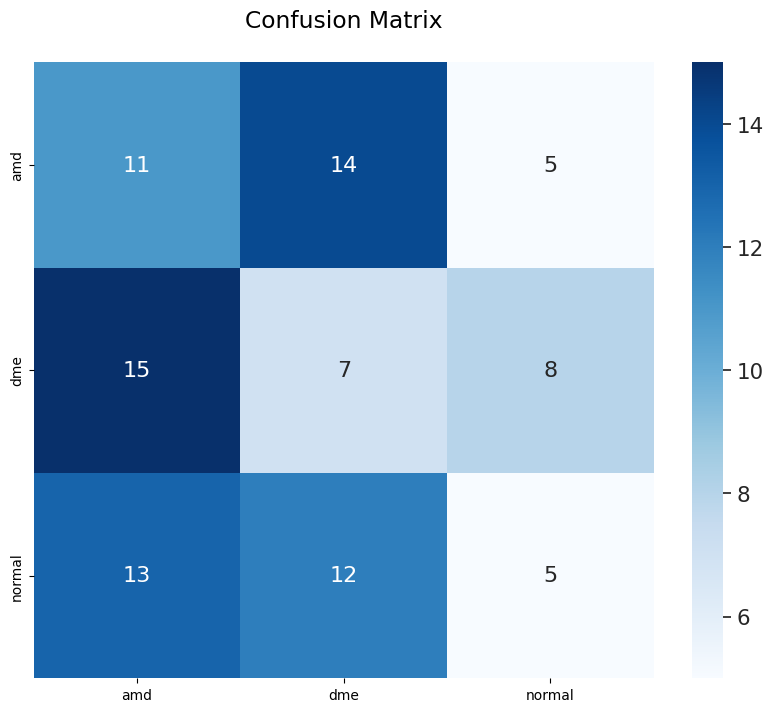

Classification Report

              precision    recall  f1-score   support

         amd       0.28      0.37      0.32        30
         dme       0.21      0.23      0.22        30
      normal       0.28      0.17      0.21        30

    accuracy                           0.26        90
   macro avg       0.26      0.26      0.25        90
weighted avg       0.26      0.26      0.25        90



In [12]:
Y_pred = model.predict(testdata, 90 // batchSize+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)
df_cm = pd.DataFrame(cm, list(testdata.class_indices.keys()), list(testdata.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(testdata.class_indices.keys())
print(classification_report(testdata.classes, y_pred, target_names=target_names))
